# Dataset Description
This dataset contains a large number of segmented nuclei images. The images were acquired under a variety of conditions and vary in the cell type, magnification, and imaging modality (brightfield vs. fluorescence). The dataset is designed to challenge an algorithm's ability to generalize across these variations.

Each image is represented by an associated ImageId. Files belonging to an image are contained in a folder with this ImageId. Within this folder are two subfolders:

images contains the image file.
masks contains the segmented masks of each nucleus. This folder is only included in the training set. Each mask contains one nucleus. Masks are not allowed to overlap (no pixel belongs to two masks).
The second stage dataset will contain images from unseen experimental conditions. To deter hand labeling, it will also contain images that are ignored in scoring. The metric used to score this competition requires that your submissions are in run-length encoded format. Please see the evaluation page for details.

As with any human-annotated dataset, you may find various forms of errors in the data. You may manually correct errors you find in the training set. The dataset will not be updated/re-released unless it is determined that there are a large number of systematic errors. The masks of the stage 1 test set will be released with the release of the stage 2 test set

### Download it from Kaggle
https://www.kaggle.com/competitions/data-science-bowl-2018/data


## Importing Libraries

In [ ]:
import os
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
import random

## Images Dimension

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Preparing Dataset for UNET model

In [1]:
TRAIN_PATH ='stage1_train/'
TEST_PATH = 'stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids),IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids),IMG_WIDTH,IMG_HEIGHT,1), dtype=np.bool8)

#train images
print('Resizing training Images and Masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT,IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool8)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

    Y_train[n] = mask

#test images
X_test = np.zeros((len(test_ids),IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
#train images
print('Resizing testing Images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT,IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!') 




c:\Users\AbdulRaheemShahzad\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\AbdulRaheemShahzad\AppData\Local\Temp\ipykernel_13820\2898996300.py:22: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  Y_train = np.zeros((len(train_ids),IMG_WIDTH,IMG_HEIGHT,1), dtype=np.bool8)


Resizing training Images and Masks


  0%|          | 0/670 [00:00<?, ?it/s]C:\Users\AbdulRaheemShahzad\AppData\Local\Temp\ipykernel_13820\2898996300.py:31: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool8)
100%|██████████| 670/670 [14:35<00:00,  1.31s/it] 


Resizing testing Images


100%|██████████| 65/65 [00:04<00:00, 15.47it/s]

Done!


# UNET Architecture

In [2]:


inputs = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal',padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
p1 = tf.keras.layers.MaxPool2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
p2 = tf.keras.layers.MaxPool2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
p3 = tf.keras.layers.MaxPool2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
p4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)

# Up-sampling path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)           0         ['dropout[0][0]']             
 D)                                                                                           

## Training Model

In [4]:
# model check point
checkcpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5',verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]


result = model.fit(X_train,Y_train, validation_split=0.1, batch_size=16, epochs=30, callbacks=callbacks)


Epoch 1/30
38/38 [==============================] - 86s 2s/step - loss: 5.4668 - accuracy: 0.6792 - val_loss: 1.5864 - val_accuracy: 0.8580
Epoch 2/30
38/38 [==============================] - 74s 2s/step - loss: 0.9170 - accuracy: 0.8501 - val_loss: 0.2783 - val_accuracy: 0.8618
Epoch 3/30
38/38 [==============================] - 51s 1s/step - loss: 0.3647 - accuracy: 0.8356 - val_loss: 0.2793 - val_accuracy: 0.8610
Epoch 4/30
38/38 [==============================] - 51s 1s/step - loss: 0.3034 - accuracy: 0.8654 - val_loss: 0.1925 - val_accuracy: 0.9080
Epoch 5/30
38/38 [==============================] - 53s 1s/step - loss: 0.2607 - accuracy: 0.8881 - val_loss: 0.1820 - val_accuracy: 0.9099
Epoch 6/30
38/38 [==============================] - 64s 2s/step - loss: 0.2301 - accuracy: 0.9087 - val_loss: 0.1860 - val_accuracy: 0.9340
Epoch 7/30
38/38 [==============================] - 67s 2s/step - loss: 0.2249 - accuracy: 0.9186 - val_loss: 0.1488 - val_accuracy: 0.9463
Epoch 8/30
38/38 [==

# Checking on Ramdom Images from Data

3/3 [==============================] - 1s 368ms/step


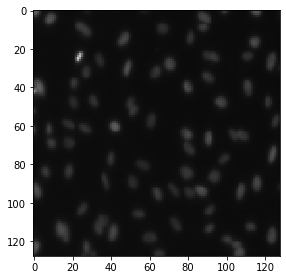

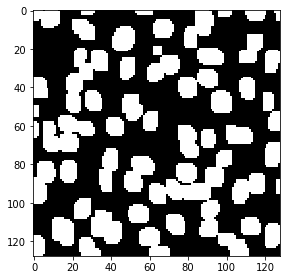

c:\Users\AbdulRaheemShahzad\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


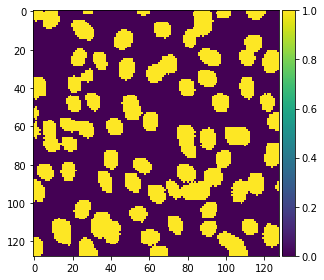

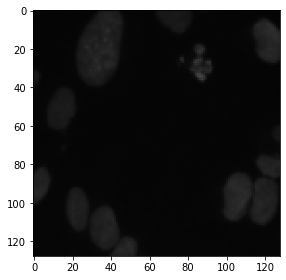

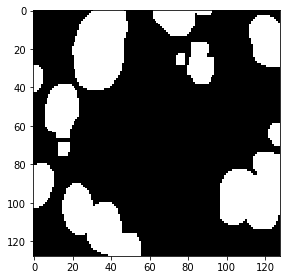

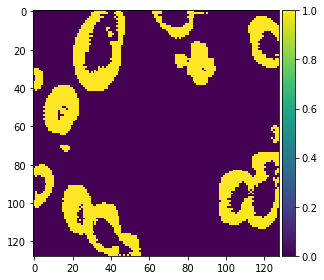

In [6]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

#perform a sanity check on some random training samples

ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

#perform sanity check
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
